Notebook for plotting the results of the clustering measurements on the 4FS data

In [22]:
%load_ext autoreload
%autoreload

# import modules
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

# import sys
# sys.path.append('../clustering_pipeline/')

# from imports import *
from data_io import load_object, read_to_df
from structures import catalogue_variables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# load the key paths / variables class object
cat_vars = load_object('catalogue_vars/2021_05_catalogue_vars')
cat_vars.__dict__

{'vars_name': '2021_05',
 'root_path': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/',
 'data_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Input/',
 'data_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Output/',
 'mask_path': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/survey_masks/',
 'randoms_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Input/randoms/',
 'randoms_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Output/randoms/',
 'results_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/results/2021_05_Input/',
 'results_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/results/2021_05_Output/',
 'plots_validation': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/plots_validation/2021_05/',
 'plots_results': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/plots_results/2021_05/',
 'catalogues': ['input', 'output'],
 'tracers': [

In [24]:
# First lets have a look at what the results tables look like for one of the tracers in the output catalogues

tracer = 'BG'

# load the pickle objects containing the results
res_wt = load_object(cat_vars.results_output + 'results_' + tracer + '_wtheta')
res_xi = load_object(cat_vars.results_output + 'results_' + tracer + '_xi')
res_wp = load_object(cat_vars.results_output + 'results_' + tracer + '_wp')

print(res_wt.__dict__.keys(), '\n') # just prints all the variables of the class

# to access the data of the object just do e.g.:
test_result = res_wt.res_avg
print(test_result, '\n')

# the below calls the print function of the class that displays the stored data via a pandas DataFrame
res_wt.print_results()
res_xi.print_results()
res_wp.print_results()


dict_keys(['bin_mid', 'res_1', 'res_2', 'res_avg', 'err_1', 'err_2', 'err_avg', 'cov1', 'cov2', 'cov_avg', 'DD1', 'DD2', 'RR1', 'RR2', 'DR1', 'DR2', 'res_1_uncorr', 'res_2_uncorr', 'fibre_1_corr', 'fibre_2_corr']) 

[ 3.39316935e-01  2.64459118e-01  1.96756409e-01  1.45730701e-01
  1.11686782e-01  8.38381345e-02  6.80927840e-02  5.47487824e-02
  4.11121788e-02  3.20896110e-02  2.54838280e-02  1.87579738e-02
  1.23746745e-02  9.02914740e-03  3.51140015e-03 -2.40110452e-04
 -3.65579251e-04 -1.69806532e-03 -1.27419248e-04  1.12972325e-04] 



,bin_mid,res_1,err_1,res_2,err_2,res_avg,err_avg,res_1_uncorr,fibre_1_corr,res_2_uncorr,fibre_2_corr,DD1,DD2,RR1,RR2,DR1,DR2
0,0.012159,0.338482,0.010174,0.340452,0.011862,0.339317,0.007723,0.249740,1.072282,0.244746,1.078130,3.362600e+04,1.876300e+04,6.726988e+07,3.801016e+07,2.684847e+06,1.510956e+06
1,0.017164,0.267143,0.006319,0.260105,0.008049,0.264459,0.004970,0.190517,1.065281,0.185738,1.063663,6.357500e+04,3.536100e+04,1.330266e+08,7.511812e+07,5.323529e+06,2.989366e+06
2,0.024269,0.196441,0.002446,0.198834,0.006278,0.196756,0.002279,0.130616,1.058924,0.138738,1.053454,1.208060e+05,6.796300e+04,2.656039e+08,1.500116e+08,1.064635e+07,5.979156e+06
3,0.034288,0.146525,0.003536,0.144243,0.004838,0.145731,0.002855,0.094852,1.047684,0.088666,1.051648,2.338720e+05,1.298500e+05,5.300619e+08,2.994465e+08,2.127152e+07,1.194666e+07
4,0.048443,0.111121,0.002728,0.112592,0.003451,0.111687,0.002140,0.072050,1.036735,0.070391,1.039703,4.577300e+05,2.557370e+05,1.056983e+09,5.970610e+08,4.247574e+07,2.388142e+07
5,0.068462,0.085560,0.002848,0.082146,0.002824,0.083838,0.002005,0.063340,1.021012,0.058949,1.022062,9.076090e+05,5.042040e+05,2.107982e+09,1.189980e+09,8.482081e+07,4.759673e+07
6,0.096726,0.069045,0.001656,0.066262,0.002296,0.068093,0.001343,0.061731,1.006925,0.058185,1.007683,1.807442e+06,1.005597e+06,4.203309e+09,2.373705e+09,1.691535e+08,9.497166e+07
7,0.136669,0.056428,0.001799,0.053896,0.001282,0.054749,0.001044,0.053400,1.002885,0.049211,1.004483,3.576287e+06,1.989351e+06,8.369105e+09,4.723687e+09,3.370909e+08,1.892577e+08
8,0.193091,0.041900,0.001464,0.040333,0.001456,0.041112,0.001032,0.041957,0.999945,0.040289,1.000043,7.049412e+06,3.921808e+06,1.667140e+10,9.403283e+09,6.716424e+08,3.765239e+08
9,0.272835,0.032657,0.001569,0.031325,0.001822,0.032090,0.001189,0.032579,1.000075,0.029355,1.001918,1.390926e+07,7.735170e+06,3.311269e+10,1.869073e+10,1.335708e+09,7.495163e+08


,bin_mid,res_1,err_1,res_2,err_2,res_avg,err_avg,DD1,DD2,RR1,RR2,DR1,DR2
0,5.311615,0.952237,0.000469,0.946569,0.000129,0.946969,0.000125,392421.0,218939.0,4.949186e+08,2.800331e+08,1.992487e+07,1.120677e+07
1,5.960732,0.787402,0.000676,0.771006,0.000185,0.772148,0.000178,503838.0,279357.0,6.940459e+08,3.925478e+08,2.794690e+07,1.572062e+07
2,6.689529,0.649685,0.000605,0.640985,0.000231,0.642090,0.000216,655707.0,364468.0,9.786051e+08,5.533291e+08,3.941344e+07,2.214374e+07
3,7.506017,0.532444,0.000830,0.525689,0.000425,0.527090,0.000378,858296.0,477435.0,1.379754e+09,7.796885e+08,5.555316e+07,3.120713e+07
4,8.421739,0.433585,0.000750,0.425320,0.000345,0.426764,0.000313,1132516.0,628515.0,1.944997e+09,1.098555e+09,7.835573e+07,4.398264e+07
5,9.449605,0.347993,0.001304,0.340380,0.000642,0.341864,0.000576,1501087.0,833353.0,2.741950e+09,1.547660e+09,1.104657e+08,6.200658e+07
6,10.604429,0.277761,0.001097,0.277509,0.000519,0.277555,0.000469,2005653.0,1118697.0,3.864516e+09,2.179660e+09,1.557167e+08,8.734046e+07
7,11.898979,0.219251,0.001827,0.215243,0.000464,0.215486,0.000450,2698315.0,1498508.0,5.446546e+09,3.069473e+09,2.195301e+08,1.230028e+08
8,13.351893,0.171969,0.001785,0.167707,0.000651,0.168208,0.000612,3654731.0,2027024.0,7.674725e+09,4.320915e+09,3.093537e+08,1.731685e+08
9,14.981701,0.130520,0.002429,0.126074,0.001258,0.127014,0.001117,4969175.0,2751709.0,1.081259e+10,6.081742e+09,4.359668e+08,2.437709e+08


,bin_mid,res_1,err_1,res_2,err_2,res_avg,err_avg,DD1,DD2,RR1,RR2,DR1,DR2
0,5.296269,14.615248,0.304853,14.461360,0.273973,14.530117,0.203774,None,None,None,None,None,None
1,5.942511,13.108132,0.353700,12.519916,0.266242,12.732661,0.212714,None,None,None,None,None,None
2,6.667607,11.602167,0.408602,11.106050,0.209312,11.209177,0.186292,None,None,None,None,None,None
3,7.481178,10.192719,0.367467,9.779406,0.198596,9.872837,0.174713,None,None,None,None,None,None
4,8.394020,8.881899,0.249096,8.280875,0.216501,8.539517,0.163407,None,None,None,None,None,None
5,9.418245,7.642346,0.346481,7.108085,0.149923,7.192340,0.137594,None,None,None,None,None,None
6,10.567445,6.432632,0.349383,6.015748,0.141443,6.074451,0.131107,None,None,None,None,None,None
7,11.856869,5.260046,0.273940,4.925275,0.113577,4.974380,0.104917,None,None,None,None,None,None
8,13.303625,4.432153,0.296651,4.008789,0.105469,4.056298,0.099375,None,None,None,None,None,None
9,14.926913,3.545780,0.269121,3.135101,0.099268,3.184285,0.093134,None,None,None,None,None,None


In [4]:
%%time

# look at completeness of the output catalogues
for tracer in cat_vars.tracers:
    target_in = cat_vars.data_input + 'input_reduced_' + tracer + '.fits'
    target_out = cat_vars.data_output + 'output_reduced_' + tracer + '.fits'
    df_in = read_to_df(target_in)
    df_out = read_to_df(target_out)
    N_in = len(df_in)
    N_out = len(df_out)
    print('For %s there are %s input and %s output targets (%s %% completeness)'%(tracer, N_in, N_out, round(N_out*100/N_in,1)))
    

For BG there are 1892657 input and 1415662 output targets (74.8 % completeness)
For LRG there are 3023501 input and 1954560 output targets (64.6 % completeness)
For QSO there are 1057486 input and 787016 output targets (74.4 % completeness)
For LyA there are 375468 input and 300587 output targets (80.1 % completeness)
CPU times: user 4.54 s, sys: 1.73 s, total: 6.27 s
Wall time: 6.28 s


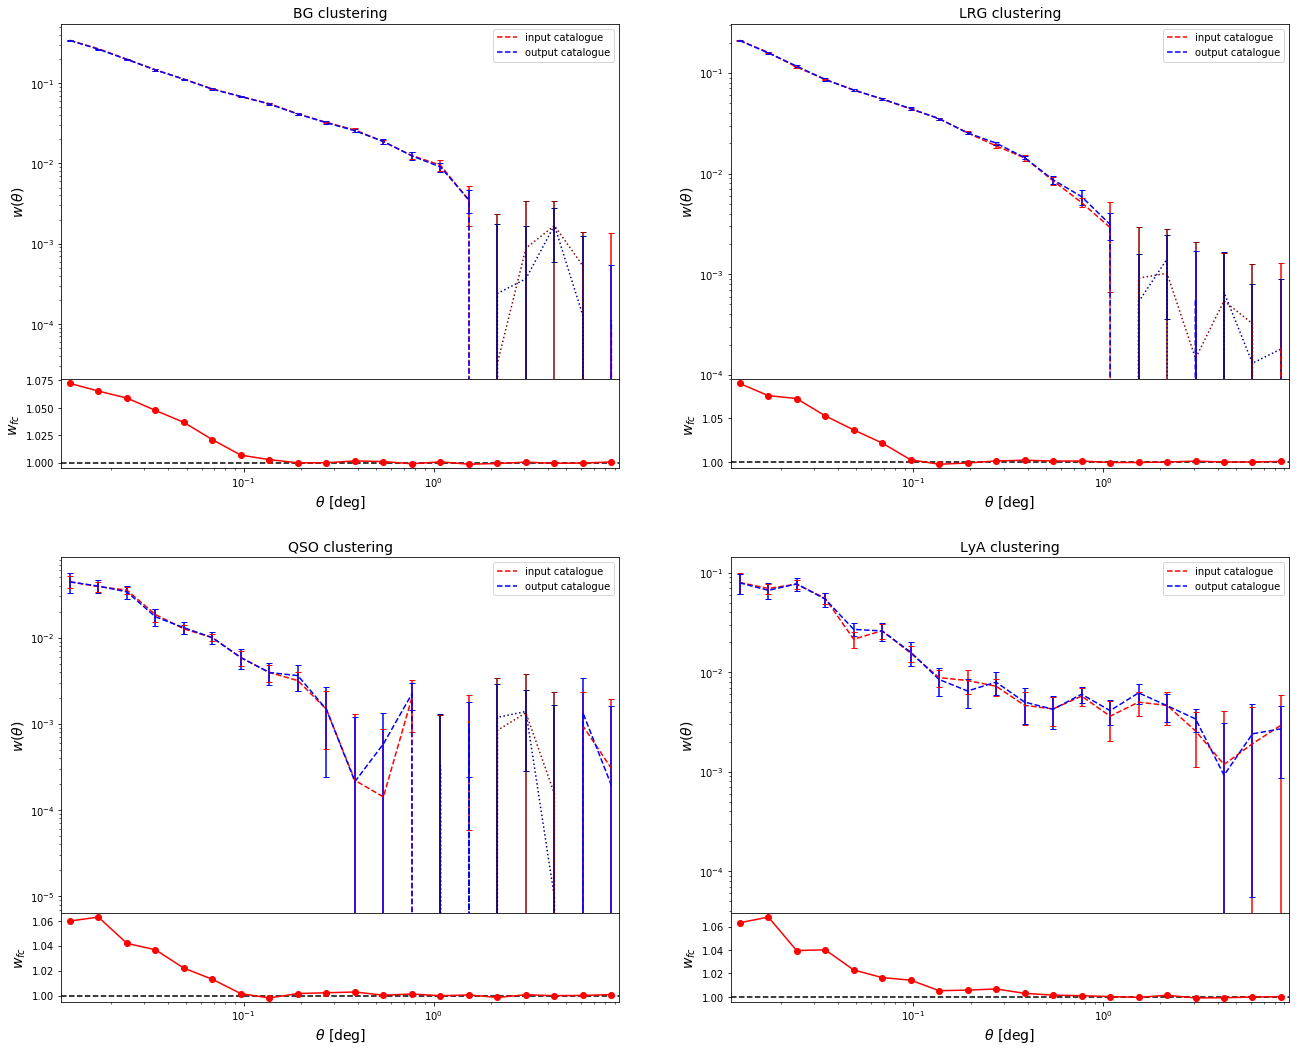

In [7]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(22, 18))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i in range(4):
    tracer = cat_vars.tracers[i]
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0., height_ratios=[4,1])
    
    # load and get the data to plot
    results_file_in = cat_vars.results_input + 'results_' + tracer +'_wtheta'
    results_file_out = cat_vars.results_output + 'results_' + tracer +'_wtheta'
    res_wt_in = load_object(results_file_in)
    res_wt_out = load_object(results_file_out)
    wt_in_theta = res_wt_in.bin_mid
    wt_in_res = res_wt_in.res_avg
    wt_in_err = res_wt_in.err_avg
    wt_out_theta = res_wt_out.bin_mid
    wt_out_res = res_wt_out.res_avg
    wt_out_err = res_wt_out.err_avg
    w_fc_1 = res_wt_out.fibre_1_corr
    w_fc_2 = res_wt_out.fibre_2_corr
    
    
    
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        ax.set_xscale('log')
#         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
#         t.set_ha('center')
    
        # upper plot
        if j == 0:
            ax.set_title('%s clustering'%(tracer), size=14)
            ax.set_yscale('log')
            ax.set_xticks([])
            ax.set_xlim(min(wt_out_theta)*0.9, max(wt_out_theta)*1.1)
            ax.set_ylabel(r'$w(\theta)$', size=14)
            
            ax.errorbar(wt_in_theta[wt_in_res>0], wt_in_res[wt_in_res>0], yerr=wt_in_err[wt_in_res>0], capsize=3, color='red', ls='')
            ax.errorbar(wt_in_theta[wt_in_res<0], -wt_in_res[wt_in_res<0], yerr=wt_in_err[wt_in_res<0], capsize=3, color='darkred', ls='')
            ax.errorbar(wt_out_theta[wt_out_res>0], wt_out_res[wt_out_res>0], yerr=wt_out_err[wt_out_res>0], capsize=3, color='blue', ls='')
            ax.errorbar(wt_out_theta[wt_out_res<0], -wt_out_res[wt_out_res<0], yerr=wt_out_err[wt_out_res<0], capsize=3, color='darkblue', ls='')

            ax.plot(wt_in_theta, wt_in_res, color='red', ls='--', label='input catalogue')
            ax.plot(wt_in_theta, -wt_in_res, color='darkred', ls=':')
            ax.plot(wt_out_theta, wt_out_res, color='blue', ls='--', label='output catalogue')
            ax.plot(wt_out_theta, -wt_out_res, color='darkblue', ls=':')
            
            ax.legend()
        
        # lower plot
        else:
            ax.axhline(1, c='black', ls='--')
            ax.set_xlim(min(wt_out_theta)*0.9, max(wt_out_theta)*1.1)
            ax.plot(wt_out_theta, w_fc_1, marker='o', ls='-', c='red')
#             plt.ylabel(r'$w(\theta)$', size=14)
            ax.set_xlabel(r'$\theta$ [deg]', size=14)
#             ax.set_ylabel(r'$(1 + w_{in}) / (1 + w_{out})$', size=14)
            ax.set_ylabel('$w_{fc}$', size=14)
            
            
            
#         ax.set_yticks([])
        fig.add_subplot(ax)

# plt.savefig('results_angular_fc')
plt.show()

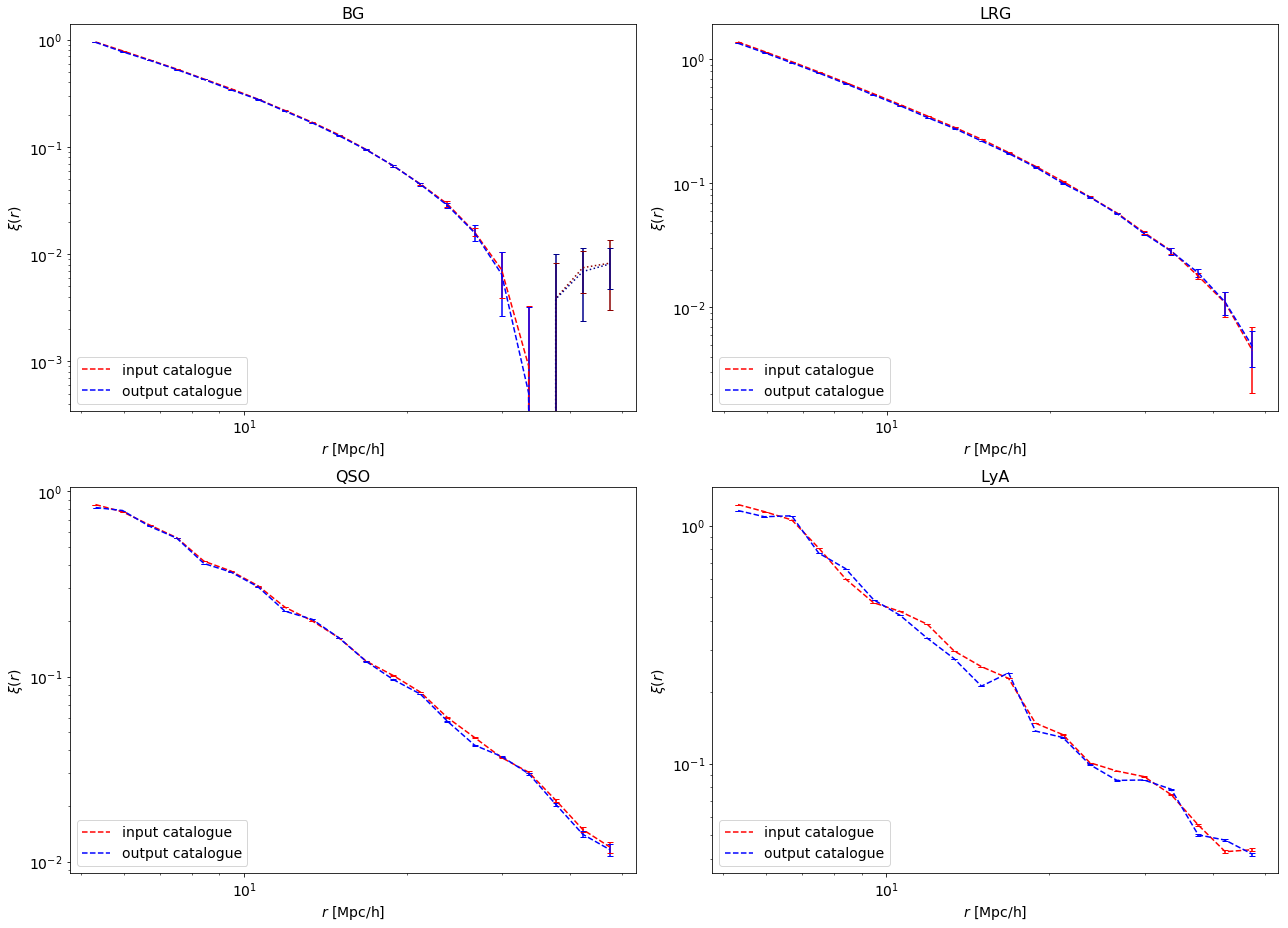

CPU times: user 2.32 s, sys: 1.03 s, total: 3.35 s
Wall time: 1.5 s


In [8]:
%%time

# for loop to plot the xi(r) results for the 4 tracers

plt.figure(figsize=(18,13))

for i, tracer in enumerate (cat_vars.tracers):
    
    results_file_in = cat_vars.results_input + 'results_' + tracer + '_xi'
    res_xi_in = load_object(results_file_in)
    results_file_out = cat_vars.results_output + 'results_' + tracer + '_xi'
    res_xi_out = load_object(results_file_out)
    
    plt.subplot(2,2,i+1)
    plt.title('%s'%(tracer), size=16)
    plt.ylabel(r'$\xi(r)$', size=14)
    plt.xlabel(r'$r$ [Mpc/h]', size=14)
    plt.yscale('log')
    plt.xscale('log')
    plt.yticks(size=14)
    plt.xticks(size=14)
    
    xi_in_r = res_xi_in.bin_mid
    xi_in_res = res_xi_in.res_avg
    xi_in_err = res_xi_in.err_avg
    xi_out_r = res_xi_out.bin_mid
    xi_out_res = res_xi_out.res_avg
    xi_out_err = res_xi_out.err_avg
    
    plt.errorbar(xi_in_r[xi_in_res>0], xi_in_res[xi_in_res>0], yerr=xi_in_err[xi_in_res>0], capsize=3, color='red', ls='')
    plt.errorbar(xi_in_r[xi_in_res<0], -xi_in_res[xi_in_res<0], yerr=xi_in_err[xi_in_res<0], capsize=3, color='darkred', ls='')
    plt.errorbar(xi_out_r[xi_out_res>0], xi_out_res[xi_out_res>0], yerr=xi_out_err[xi_out_res>0], capsize=3, color='blue', ls='')
    plt.errorbar(xi_out_r[xi_out_res<0], -xi_out_res[xi_out_res<0], yerr=xi_out_err[xi_out_res<0], capsize=3, color='darkblue', ls='')
    
    plt.plot(xi_in_r, xi_in_res, color='red', ls='--', label='input catalogue')
    plt.plot(xi_in_r, -xi_in_res, color='darkred', ls=':')
    plt.plot(xi_out_r, xi_out_res, color='blue', ls='--', label='output catalogue')
    plt.plot(xi_out_r, -xi_out_res, color='darkblue', ls=':')
    
#     plt.errorbar(df_wt_in['theta_mid'].values[ind_in], df_wt_in['res_avg'].values[ind_in]*-1, yerr=df_wt_in['err_avg'].values[ind_in],linestyle=':', color='green', label='input catalogue')
#     plt.errorbar(df_wt_out['theta_mid'].values[ind_out], df_wt_out['res_avg'].values[ind_out]*-1, yerr=df_wt_out['err_avg'].values[ind_out],linestyle=':', color='blue', label='output catalogue')
    

    plt.legend(loc=3, fontsize=14)

# plt.savefig('3d_clustering.png')
plt.tight_layout()
plt.show()

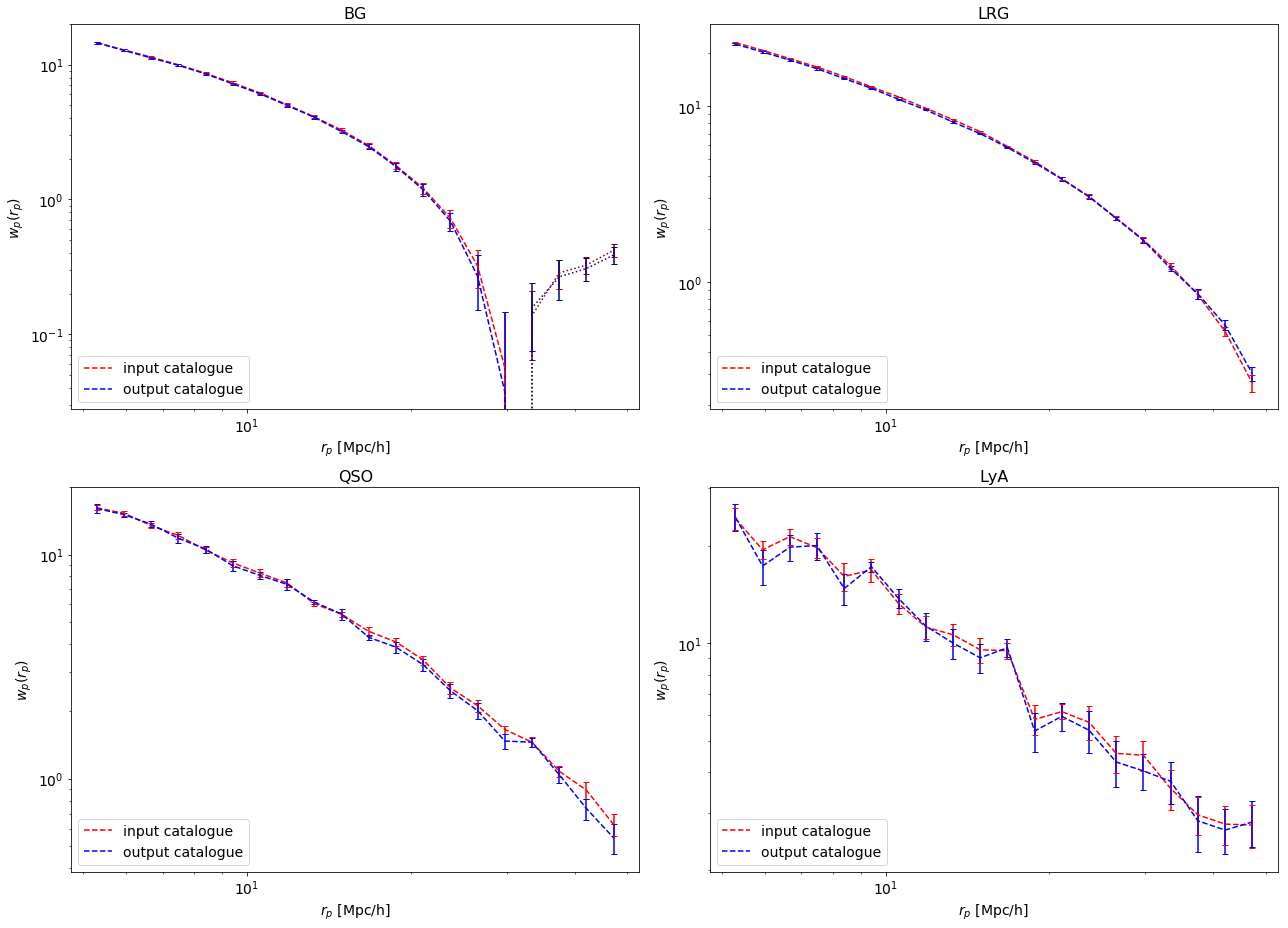

CPU times: user 2.32 s, sys: 995 ms, total: 3.32 s
Wall time: 1.44 s


In [9]:
%%time

# for loop to plot the w_p(r_p) results for the 4 tracers

plt.figure(figsize=(18,13))

for i, tracer in enumerate (cat_vars.tracers):
    
    results_file_in = cat_vars.results_input + 'results_' + tracer + '_wp'
    res_wp_in = load_object(results_file_in)
    results_file_out = cat_vars.results_output + 'results_' + tracer + '_wp'
    res_wp_out = load_object(results_file_out)
    
    plt.subplot(2,2,i+1)
    plt.title('%s'%(tracer), size=16)
    plt.ylabel(r'$w_p(r_p)$', size=14)
    plt.xlabel(r'$r_p$ [Mpc/h]', size=14)
    plt.yscale('log')
    plt.xscale('log')
    plt.yticks(size=14)
    plt.xticks(size=14)
    
    wp_in_r = res_wp_in.bin_mid
    wp_in_res = res_wp_in.res_avg
    wp_in_err = res_wp_in.err_avg
    wp_out_r = res_wp_out.bin_mid
    wp_out_res = res_wp_out.res_avg
    wp_out_err = res_wp_out.err_avg
    
    plt.errorbar(wp_in_r[wp_in_res>0], wp_in_res[wp_in_res>0], yerr=wp_in_err[wp_in_res>0], capsize=3, color='red', ls='')
    plt.errorbar(wp_in_r[wp_in_res<0], -wp_in_res[wp_in_res<0], yerr=wp_in_err[wp_in_res<0], capsize=3, color='darkred', ls='')
    plt.errorbar(wp_out_r[wp_out_res>0], wp_out_res[wp_out_res>0], yerr=wp_out_err[wp_out_res>0], capsize=3, color='blue', ls='')
    plt.errorbar(wp_out_r[wp_out_res<0], -wp_out_res[wp_out_res<0], yerr=wp_out_err[wp_out_res<0], capsize=3, color='darkblue', ls='')
    
    plt.plot(wp_in_r, wp_in_res, color='red', ls='--', label='input catalogue')
    plt.plot(wp_in_r, -wp_in_res, color='darkred', ls=':')
    plt.plot(wp_out_r, wp_out_res, color='blue', ls='--', label='output catalogue')
    plt.plot(wp_out_r, -wp_out_res, color='darkblue', ls=':')
    
    plt.legend(loc=3, fontsize=14)

# plt.savefig('projected_clustering.png')
plt.tight_layout()
plt.show()

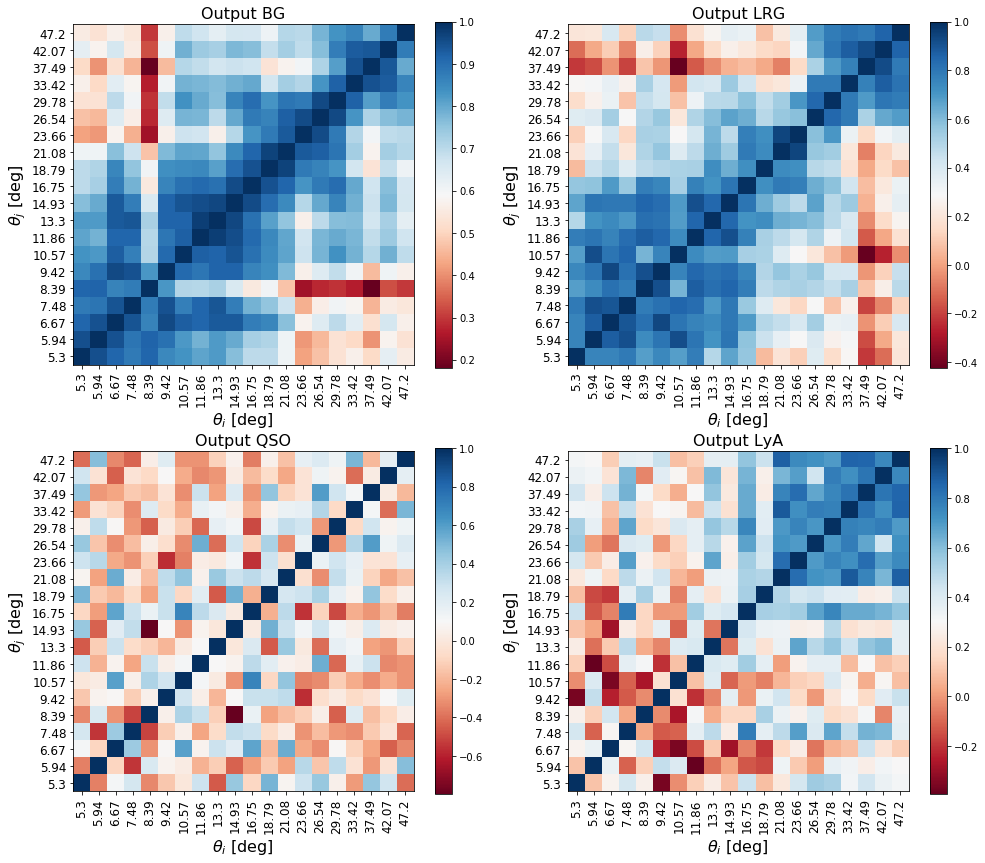

In [15]:
# look at the correlation matrix, calculated from covariance

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

catalogue = 'output' # ['input' or 'output']
statistic = 'wp' # ['wtheta', 'xi', or 'wp']

plt.figure(figsize=(14,12))

for i, tracer in enumerate(cat_vars.tracers):
    plt.subplot(2,2,i+1)
    plt.title('Output %s'%(tracer), size=16)
    plt.xlabel(r'$\theta_i$ [deg]', size=16)
    plt.ylabel(r'$\theta_j$ [deg]', size=16)


    # load covariance and get correlation matrix, then plot
    path = ''
    if catalogue == 'input':
        path += cat_vars.results_input + 'results_' + tracer + '_'
    else:
        path += cat_vars.results_output + 'results_' + tracer + '_'

    res = load_object(path + statistic)
    corr_m = correlation_from_covariance(res.cov_avg)

    plt.imshow(np.flip(corr_m, axis=0), cmap=plt.get_cmap('RdBu'))
    plt.xticks(np.linspace(0,19,20), np.round(res.bin_mid,2), rotation='vertical', size=12)
    plt.yticks(np.linspace(0,19,20), np.flip(np.round(res.bin_mid,2)), size=12)
    
    plt.colorbar()


plt.tight_layout()
# plt.savefig('correlation_matrix_output.png')
plt.show()



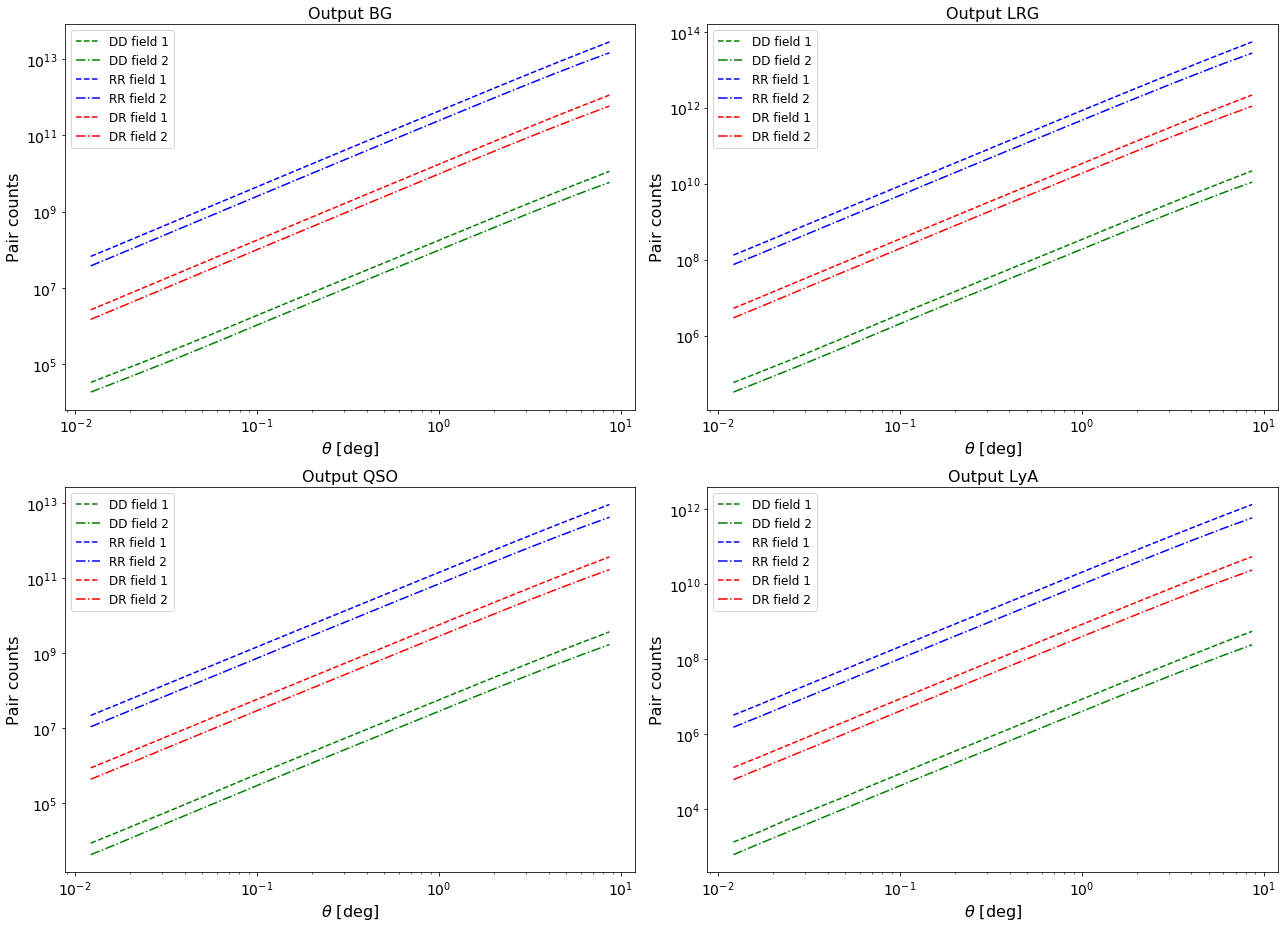

In [6]:
# plot the pair counts for output catalogues

plt.figure(figsize=(18,13))

for i, tracer in enumerate(cat_vars.tracers):
    
    # load the results file
    res = load_object(cat_vars.results_output + 'results_' + tracer + '_wtheta')
    
    plt.subplot(2,2,i+1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Output %s'%(tracer), size=16)
    plt.xlabel(r'$\theta$ [deg]', size=16)
    plt.ylabel('Pair counts', size=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    plt.plot(res.bin_mid, res.DD1, c = 'green', ls='--', label='DD field 1')
    plt.plot(res.bin_mid, res.DD2, c = 'green', ls='-.', label='DD field 2')
    
    plt.plot(res.bin_mid, res.RR1, c = 'blue', ls='--', label='RR field 1')
    plt.plot(res.bin_mid, res.RR2, c = 'blue', ls='-.', label='RR field 2')
    
    plt.plot(res.bin_mid, res.DR1, c = 'red', ls='--', label='DR field 1')
    plt.plot(res.bin_mid, res.DR2, c = 'red', ls='-.', label='DR field 2')
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    
    